In [13]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns, IPython
import agentpy as ap
import numpy as np

from utils import Encodable

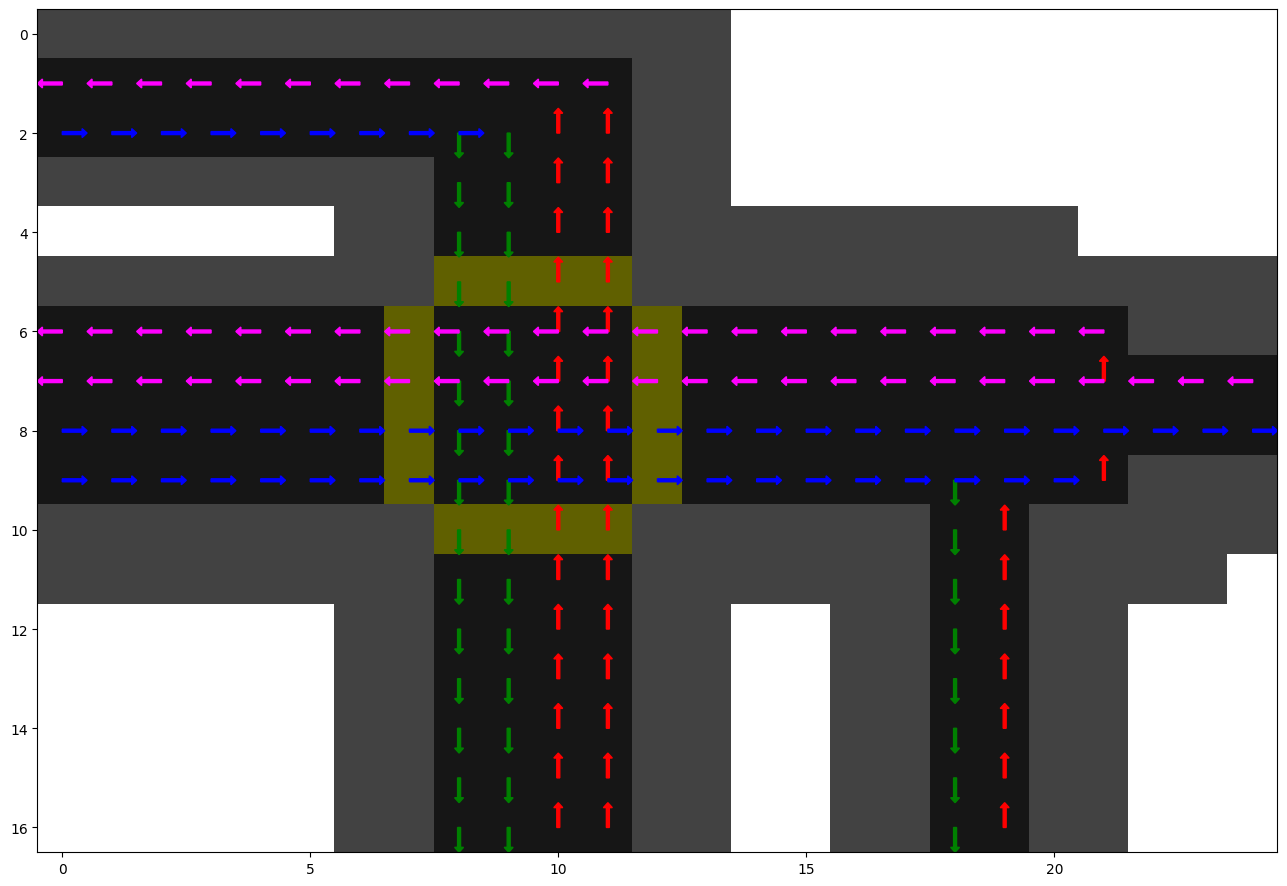

In [14]:
# Road types
NO=0    # Inaccessible
RO=1    # Road
SI=2    # Sidewalk
RC=4|RO # Pedestrian crossing (road + crossing)
# BS=8|SI # Bus stop

# Direction constants
ND=1 # North
SD=2 # South
ED=4 # East
WD=8 # West

AL=ND|SD|ED|WD # All directions
NE=ND|ED       # North east
SE=SD|ED       # South east
NW=ND|WD       # North west
SW=SD|WD       # South west
BL=ND|SD       # Block (vertical)
IL=ED|WD       # Inline (horizontal)

NT=ND|IL       # North T (nort, east, west)
ST=SD|IL       # South T (south, east, west)
ET=ED|BL       # East T (east, north, south)
WT=WD|BL       # West T (west, north, south)

UP = NT|NE|NW
DOWN = ST|SE|SW
RIGHT = ET|NE|SE
LEFT = WT|NW|SW

DIR_VECS = {
    ND: ( 1, 0),
    SD: (-1, 0),
    ED: ( 0, 1),
    WD: ( 0,-1),
    NE: ( 1, 1),
    SE: (-1, 1),
    NW: ( 1,-1),
    SW: (-1,-1),
}

LIGHT_SHIFT = 16 # Traffic light IDs will start at this bit index

def PlotState(road: np.ndarray, dir: np.ndarray, ax: plt.Axes):
    colors = {
        NO: '#ffffff', # Inaccessible
        RO: '#161616', # Road
        SI: '#424242', # Sidewalk
        RC: '#606000', # Pedestrian crossing
        # BS: '#824242', # Bus stop
    }

    lightMask = (1<<LIGHT_SHIFT) - 1

    ap.gridplot(road & lightMask, ax=ax, color_dict=colors, convert=True)

    for (rows, cols), x in np.ndenumerate(dir):
        if x & ND: # Goes north
            ax.add_patch(plt.Arrow(cols,rows,0,-0.5,width=0.3, color='red'))
        if x & SD: # Goes south
            ax.add_patch(plt.Arrow(cols,rows,0,0.5,width=0.3, color='green'))
        if x & ED: # Goes east
            ax.add_patch(plt.Arrow(cols,rows,0.5,0,width=0.3, color='blue'))
        if x & WD: # Goes west
            ax.add_patch(plt.Arrow(cols,rows,-0.5,0,width=0.3, color='magenta'))
'''
Roads are encoded using bit masks thus a road can have many types eg.
RO=1    # Road
RC=4|RO # Pedestrian crossing (road + crossing)
this allows agents to fetch the road types they need
'''

'''
Tiles are grouped into a traffic light using numerical IDs they are encoded on 
the same road-type bit mask.
Leaving the less significant 16 bits (0xffff0000) for the light ID 
and the more significant 16 bits (0xffff) for the road types
 - to create a light, shift the ID 16 bits. (L1 = 1 << 16)

 - to group tiles, logically OR the tile type with the group ID. (RC|L1)

 - to create a traffic light group add all your lights into a tuple on the INTERSECTIONS variable
    the light system will automatically shift between the green lights on the tuple
'''

#    V group id
L1 = 1 << LIGHT_SHIFT
L2 = 2 << LIGHT_SHIFT
#                 V - this creates one intersection with two traffic lights
INTERSECTIONS = [(L1, L2)]

roadType = np.array([
    [SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO],
    [RO,RO,RO,RO,RO,RO,RO,RO,RO,RO,RO,RO,SI,SI,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO],
    [RO,RO,RO,RO,RO,RO,RO,RO,RO,RO,RO,RO,SI,SI,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO],
    [SI,SI,SI,SI,SI,SI,SI,SI,RO,RO,RO,RO,SI,SI,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO],
    [NO,NO,NO,NO,NO,NO,SI,SI,RO,RO,RO,RO,SI,SI,SI,SI,SI,SI,SI,SI,SI,NO,NO,NO,NO],
    [SI,SI,SI,SI,SI,SI,SI,SI,RC|L2,RC|L2,RC|L2,RC|L2,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI],
    [RO,RO,RO,RO,RO,RO,RO,RC|L1,RO,RO,RO,RO,RC|L1,RO,RO,RO,RO,RO,RO,RO,RO,RO,SI,SI,SI],
    [RO,RO,RO,RO,RO,RO,RO,RC|L1,RO,RO,RO,RO,RC|L1,RO,RO,RO,RO,RO,RO,RO,RO,RO,RO,RO,RO],
    [RO,RO,RO,RO,RO,RO,RO,RC|L1,RO,RO,RO,RO,RC|L1,RO,RO,RO,RO,RO,RO,RO,RO,RO,RO,RO,RO],
    [RO,RO,RO,RO,RO,RO,RO,RC|L1,RO,RO,RO,RO,RC|L1,RO,RO,RO,RO,RO,RO,RO,RO,RO,SI,SI,SI],
    [SI,SI,SI,SI,SI,SI,SI,SI,RC|L2,RC|L2,RC|L2,RC|L2,SI,SI,SI,SI,SI,SI,RO,RO,SI,SI,SI,SI,SI],
    [SI,SI,SI,SI,SI,SI,SI,SI,RO,RO,RO,RO,SI,SI,SI,SI,SI,SI,RO,RO,SI,SI,SI,SI,NO],
    [NO,NO,NO,NO,NO,NO,SI,SI,RO,RO,RO,RO,SI,SI,NO,NO,SI,SI,RO,RO,SI,SI,NO,NO,NO],
    [NO,NO,NO,NO,NO,NO,SI,SI,RO,RO,RO,RO,SI,SI,NO,NO,SI,SI,RO,RO,SI,SI,NO,NO,NO],
    [NO,NO,NO,NO,NO,NO,SI,SI,RO,RO,RO,RO,SI,SI,NO,NO,SI,SI,RO,RO,SI,SI,NO,NO,NO],
    [NO,NO,NO,NO,NO,NO,SI,SI,RO,RO,RO,RO,SI,SI,NO,NO,SI,SI,RO,RO,SI,SI,NO,NO,NO],
    [NO,NO,NO,NO,NO,NO,SI,SI,RO,RO,RO,RO,SI,SI,NO,NO,SI,SI,RO,RO,SI,SI,NO,NO,NO],
])

'''
The available road directions are used by car agents, to define them you can use
any of the directional constants above.
To represent multiple directions with a single value we are using bit fields again
eg. 
    ND=1 # North
    ED=4 # East
    NE=ND|ED       # North east

Directions are only used for cars as of the last implementation
'''

directions = np.array([
    [NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO],
    [WD,WD,WD,WD,WD,WD,WD,WD,WD,WD,WD,WD,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO],
    [ED,ED,ED,ED,ED,ED,ED,ED,SE,SD,ND,ND,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO],
    [NO,NO,NO,NO,NO,NO,NO,NO,SD,SD,ND,ND,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO],
    [NO,NO,NO,NO,NO,NO,NO,NO,SD,SD,ND,ND,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO],
    [NO,NO,NO,NO,NO,NO,NO,NO,SD,SD,ND,ND,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO],
    [WD,WD,WD,WD,WD,WD,WD,WD,SW,SW,NW,NW,WD,WD,WD,WD,WD,WD,WD,WD,WD,WD,NO,NO,NO],
    [WD,WD,WD,WD,WD,WD,WD,WD,SW,SW,NW,NW,WD,WD,WD,WD,WD,WD,WD,WD,WD,NW,WD,WD,WD],
    [ED,ED,ED,ED,ED,ED,ED,ED,SE,SE,NE,NE,ED,ED,ED,ED,ED,ED,ED,ED,ED,ED,ED,ED,ED],
    [ED,ED,ED,ED,ED,ED,ED,ED,SE,SE,NE,NE,ED,ED,ED,ED,ED,ED,SE,ED,ED,ND,NO,NO,NO],
    [NO,NO,NO,NO,NO,NO,NO,NO,SD,SD,ND,ND,NO,NO,NO,NO,NO,NO,SD,ND,NO,NO,NO,NO,NO],
    [NO,NO,NO,NO,NO,NO,NO,NO,SD,SD,ND,ND,NO,NO,NO,NO,NO,NO,SD,ND,NO,NO,NO,NO,NO],
    [NO,NO,NO,NO,NO,NO,NO,NO,SD,SD,ND,ND,NO,NO,NO,NO,NO,NO,SD,ND,NO,NO,NO,NO,NO],
    [NO,NO,NO,NO,NO,NO,NO,NO,SD,SD,ND,ND,NO,NO,NO,NO,NO,NO,SD,ND,NO,NO,NO,NO,NO],
    [NO,NO,NO,NO,NO,NO,NO,NO,SD,SD,ND,ND,NO,NO,NO,NO,NO,NO,SD,ND,NO,NO,NO,NO,NO],
    [NO,NO,NO,NO,NO,NO,NO,NO,SD,SD,ND,ND,NO,NO,NO,NO,NO,NO,SD,ND,NO,NO,NO,NO,NO],
    [NO,NO,NO,NO,NO,NO,NO,NO,SD,SD,ND,ND,NO,NO,NO,NO,NO,NO,SD,ND,NO,NO,NO,NO,NO],
])

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)

PlotState(roadType, directions, ax)

In [15]:
def SafeSlice(arr: np.ndarray, slices: tuple[slice], padValue=0):
    '''
    Get slice copy from an numpy array padding with a constant value the 
    invalid indexes
    '''
    sl = tuple(
        slice(
            max(0, s.start), 
            min(s.stop, arr.shape[i])
        ) for i, s in enumerate(slices)
    )

    sliced = arr[sl]

    padWidth = [(
        abs(min(0, slices[i].start)), 
        max(0, slices[i].stop - arr.shape[i])
    ) for i in range(len(slices))]

    return np.pad(sliced, padWidth, mode='constant', constant_values=padValue)

In [16]:
class Agent(ap.Agent, Encodable):
    def __init__(self, model, *args, **kwargs):
        super().__init__(model, *args, **kwargs)
        self.model: CityModel # Just for typings
        self.env: CityEnv = model.env

    def isOccupied(self, move):
        """Verifica si una celda está ocupada por otro agente."""
        for agent in self.model.agents:
            if agent.getPos() == move:
                return True
        return False

    def toObject(self):
        '''
        Defines how the object will be serialized when.
        Use this to export new values to the visualization
        '''
        return {
            'id': self.id,
            'pos': self.getPos(),
            'type': self.agentType,
        }
    
    def getPos(self) -> tuple[int, int]:
        return self.model.env.positions[self]
    
    # FIXME: cambiar el nombre xd
    def isEdging(self):
        '''
        Check if the agent is in the borders of its environment
        '''
        x, y = self.getPos()
        r, c = self.env.shape

        return x <= 0 or y <= 0 or x+1 >= r or y+1 >= c

class CarAgent(Agent):
    def setup(self):
        self.agentType = 'car'
        self.is_waiting = False  # Track if the car is waiting at a red light

    def update(self):
        moves = self.getRoads()

        if len(moves) != 0:
            # Check if the car is waiting at a red light
            if self.is_waiting:
                # If the light is still red, do nothing
                if not self.canCross(self.getPos()):
                    return
                else:
                    self.is_waiting = False  # Light turned green, start moving

            # Filter available moves
            available_moves = [move for move in moves if not self.isOccupied(move)]
            if available_moves:
                choice = self.model.random.choice(available_moves)
                # Check if the chosen move is allowed (light is green)
                if self.canCross(choice):
                    self.env.move_to(self, choice)
                else:
                    self.is_waiting = True  # Light is red, stop and wait

    def canCross(self, move):
        tile = self.env.road[move]
        # Checks if the tile is accessible
        return self.env.lights.getState(tile) == 'green'

    def getRoads(self):
        dir = self.env.getDir(self)
        moves = []
        x, y = self.getPos()

        # Check for the available moves for the current road direction
        # FIXME: this brings the problem that an agent can do weird
        #        if the tile has many available directions
        #        keeping state of a previous direction and checking to avoid 
        #        things like a 180 degree turn could be a good solution
        if dir & ND:
            move = (x-1, y)
            if self.canCross(move):
                moves.append(move) # North
            
        if dir & SD:
            move = (x+1, y)
            if self.canCross(move):
                moves.append(move) # South

        if dir & ED:
            move = (x, y+1)
            if self.canCross(move):
                moves.append(move) # East
            
        if dir & WD:
            move = (x, y-1)
            if self.canCross(move):
                moves.append(move) # West

        return moves

class PedestrianAgent(Agent):
    def setup(self):
        self.agentType = 'pedestrian'

    def update(self):
        moves = self.getSidewalks()

        if len(moves) != 0:
            choice = self.model.random.choice(moves)
            self.env.move_to(self, choice)

    def canCross(self, move):
        tile = self.env.road[move]
        # Pedestrians cross when the cars are in red
        return self.env.lights.getState(tile) == 'red'

    def getSidewalks(self):
        pos = self.getPos()

        x1 = max(pos[0] - 1, 0)
        x2 = min(pos[0] + 2, self.env.road.shape[0])

        y1 = max(pos[1] - 1, 0)
        y2 = min(pos[1] + 2, self.env.road.shape[1])

        kernel = self.env.road[x1:x2, y1:y2]

        # Check for the sidewalks
        rows, cols = np.where((kernel & SI) == SI)
        rows += x1
        cols += y1
        coords = list(zip(rows, cols))

        # Check for the crossings
        cr, cc = np.where((kernel & RC) == RC)
        cr += x1
        cc += y1
        cross = list(filter( lambda x: self.canCross(x), list(zip(cr, cc))))
        
        return coords + cross

class LightSystem():
    def __init__(self, lights, green_duration=10, red_duration=10):
        self.groups = [[group, -1] for group in lights]
        self.crossings = { }
        self.green_duration = green_duration
        self.red_duration = red_duration
        self.timers = {lightID: 0 for group in lights for lightID in group}
        self.step()

    def step(self):
        for idx, (group, greenIdx) in enumerate(self.groups):
            greenIdx = (greenIdx + 1) % len(group)
            self.groups[idx][1] = greenIdx

            for i, lightID in enumerate(group):
                state = 'green' if greenIdx == i else 'red'
                self.crossings[lightID] = state
                self.timers[lightID] = self.green_duration if state == 'green' else self.red_duration

    def getState(self, ID):
        ID = ID & 0xffff0000
        return self.crossings.get(ID, 'green')

class CityEnv(ap.Grid):
    def setup(self):
        self.road: np.ndarray = self.p.road
        self.dir: np.ndarray = self.p.dir
        self.lights = LightSystem(self.p.lights)

    def getDir(self, agent: Agent):
        return self.dir[agent.getPos()]

class CityModel(ap.Model):
    def setup(self):
        # Pad the environment for despawn purposes
        self.p.road = np.pad(self.p.road, 1, 'edge')
        self.p.dir = np.pad(self.p.dir, 1)

        self.env = CityEnv(self, self.p.road.shape)
        self.agents: list[Agent]
        self.agents, agentPos = self.GenAgents(
            numCars=self.p.numCars, 
            numPed=self.p.numPedestrians
        )
        self.env.add_agents(self.agents, positions=agentPos)
        self.deleted = []

    def GenAgents(self, numCars, numPed):
        '''
        Initialize the agents and place them on random tiles they can walk on
        '''
        roads = list(zip(*np.where((self.env.road & RO) == RO)))
        sidewalks = list(zip(*np.where((self.env.road & SI) == SI)))

        self.random.shuffle(roads)
        self.random.shuffle(sidewalks)

        carPos = roads[:numCars]
        pedPos = sidewalks[:numPed]

        agents = []

        for _ in carPos:
            agents.append(CarAgent(self))

        for _ in pedPos:
            agents.append(PedestrianAgent(self))


        return agents, (carPos + pedPos)

    def step(self):
        # Step traffic lights every 8 steps
        if self.t % 8 == 0:
            self.env.lights.step()

        alive = []
        deleted: list[Agent] = []
        for agent in self.agents:
            agent.update()

            # Despawn agents on the edges
            if agent.isEdging():
                deleted.append(agent)
            else:
                alive.append(agent)

        self.env.remove_agents(deleted)
        self.agents = alive
        # Save the deleted agents IDs to send later to the simulation
        self.deleted = [x.id for x in deleted]


In [17]:
def animate(model: CityModel, ax):
    colors = {
        NO: '#ffffff', # Inaccessible
        RO: '#161616', # Road
        SI: '#424242', # Sidewalk
        RC: '#606000', # Pedestrian crossing
    }

    agentColors = {
        'car': '#ff00ff',
        'bus': '#ffff00',
        'pedestrian': '#0000ff',
        'agent': '#ffffff'
    }

    ap.gridplot(model.env.road & 0xffff, ax=ax, color_dict=colors, convert=True)

    crossings = list(zip(*np.where(
        ((model.env.road & RC) == RC) & ((model.env.road & 0xffff0000) != 0)
    )))

    for rows, cols in crossings:
        crossingId = model.env.road[(rows,cols)] & 0xffff0000
        ax.add_patch(
            plt.Rectangle(
                (cols-0.5, rows-0.5), 
                1, 1, 
                color=model.env.lights.crossings[crossingId], alpha=0.6)
        )
    
    for (rows, cols), x in np.ndenumerate(model.env.dir):
        if x & ND: # Goes north
            ax.add_patch(plt.Arrow(cols,rows,0,-0.5,width=0.3, color='red'))
        if x & SD: # Goes south
            ax.add_patch(plt.Arrow(cols,rows,0,0.5,width=0.3, color='green'))
        if x & ED: # Goes east
            ax.add_patch(plt.Arrow(cols,rows,0.5,0,width=0.3, color='blue'))
        if x & WD: # Goes west
            ax.add_patch(plt.Arrow(cols,rows,-0.5,0,width=0.3, color='magenta'))


    for agent in model.agents:
        i, j = agent.getPos()
        ax.add_patch(
            plt.Rectangle(
                (j-0.25,i-0.25), 
                0.5, 0.5, 
                color=agentColors[agent.agentType]
            )
        )

In [18]:
params = {
    'steps': 40,
    'road': roadType,
    'dir': directions,
    'numPedestrians': 15,
    'numCars': 10,
    'lights': INTERSECTIONS,
}

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
model = CityModel(params)
animation = ap.animate(model, fig, ax, animate)
IPython.display.HTML(animation.to_jshtml())